# MNIST Playground - CNN using PyTtorch  
Use PyTorch to build a simple CNN to classify the images MNIST 784 dataset. this is a multiclass classification of handwritten digtis between 0 and 9.

In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

Set random_state to be used thoughout this notebook.

In [2]:
random_state = 842
batch_size = 64
lr = 0.001
momentum = 0.9
n_epochs = 10
n_channels = 1

torch.manual_seed(random_state)

## Fetch and prepare the MNIST 784 dataset  
Fetch the MNIST 784 dataset from OpenML Datasets (https://www.openml.org/) using the `fetch_openml` function provided by sklearn. Extract the data and the class labels from the dataset and do some basic checks.

In [3]:
X, y = fetch_openml(name='mnist_784', return_X_y=True, as_frame=False, parser='auto')
print(f"Data shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"All targets: {np.unique(y)}")

Data shape: (70000, 784)
Target shape: (70000,)
All targets: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


Reshape the flat image array from $(784,)$ into the original dimension of $(28, 28)$. Because the images are gray scale images having just 1 channel the 28 X  28 image array must be packed into 1 channel creating an array of size $(1, 28, 28)$ per image.  
Using the MNIST dataset provided by `torchvision.datasets` already provide the correct array size to be used in the `Conv2d` layer directly.

In [4]:
X = np.array([[np.reshape(i, (28, 28))] for i in X])

## Visualize Random Sample  
Display some random images of handwritten digits. The images are in gray scale having just one channel. Each pixel has a value between $0$ and $255$.

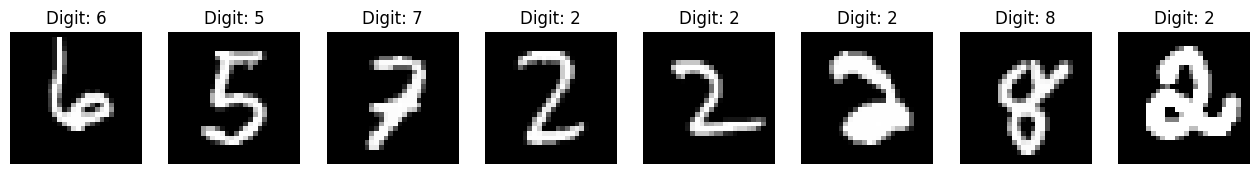

In [5]:
n_digits = 8
fig, ax = plt.subplots(nrows=1, ncols=n_digits, figsize=(16, 2))
for i, digit in enumerate(np.random.choice(len(y), n_digits)):
  ax[i].imshow(X[digit][0], cmap='gray')
  ax[i].set_title(f"Digit: {y[digit]}")
  ax[i].axis('off')
plt.show()

## Create PyTorch Tensors  
Change the data type of the data to `float32` and normalize the data. Create a PyTorch Dataset and DataLoader to be used in the training and testing of the CNN model.

In [6]:
X = X.astype(np.float32)
y = y.astype(int)
X = X/255.0  # normalize the image data

mnist_ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
mnist_ds_train, mnist_ds_test = random_split(mnist_ds, [0.75, 0.25])
train_loader = DataLoader(mnist_ds_train, shuffle=True, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(mnist_ds_test, shuffle=False, batch_size=batch_size, num_workers=2)

## CNN Class  
Definition of a simple CNN model using 2 `Conv2d` layers. Theo output of the convolutional layers gets flattened out and passed over to a network 1 hidden linear layer and a linear output layer. Max pooling gets applied to both convolutional layers. ReLU is used as a non-linearity.

In [7]:
class CNN(nn.Module):
  def __init__(self, n_channels, n_classes):
    super(CNN, self).__init__()

    # first convolutional layer
    self.conv1 = nn.Conv2d(n_channels, 8, 4)
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    self.relu1 = nn.ReLU()

    # second convolutional layer
    self.conv2 = nn.Conv2d(8, 16, 4)
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    self.relu2 = nn.ReLU()

    # fully connected layers
    self.fc1 = nn.Linear(in_features=16*4*4, out_features=128)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    # forward pass first convolutional layer
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.relu1(x)

    # forward pass second convolutional layer
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.relu2(x)

    # flatten out
    x = torch.flatten(x, 1)

    # forward pass fully connected layers
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc2(x)

    return x

Instantiate the CNN model. Use cross entropy as the loss function and stochastic gradient decent as the optimizer.

In [8]:
mnist_cnn = CNN(n_channels=n_channels, n_classes=len(np.unique(y)))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(mnist_cnn.parameters(), lr=lr, momentum=momentum)

print('Model architecture:')
print(mnist_cnn)

Model architecture:
CNN(
  (conv1): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Training the CNN  
Training the model using 10 epochs and a batch size of 64.

In [9]:
print('>>Begin Training')
mnist_cnn.train()

for epoch in range(0, n_epochs):
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(train_loader, 0):
    outputs = mnist_cnn(inputs)

    optimizer.zero_grad()
    cnn_loss = loss_fn(outputs, labels)
    cnn_loss.backward()
    optimizer.step()

    running_loss += cnn_loss.item()

    if (i+1) % 200 == 0:
      print(f"Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(mnist_ds_train)//64}], Loss: {running_loss/200}")
      running_loss = 0.0

print('<<End Training')

>>Begin Training
Epoch [1/10], Step [200/820], Loss: 2.2995485723018647
Epoch [1/10], Step [400/820], Loss: 2.281440360546112
Epoch [1/10], Step [600/820], Loss: 2.2054485988616945
Epoch [1/10], Step [800/820], Loss: 1.4281196096539497
Epoch [2/10], Step [200/820], Loss: 0.5677465109527111
Epoch [2/10], Step [400/820], Loss: 0.45663161046802997
Epoch [2/10], Step [600/820], Loss: 0.3811910054832697
Epoch [2/10], Step [800/820], Loss: 0.32993892319500445
Epoch [3/10], Step [200/820], Loss: 0.2969272279366851
Epoch [3/10], Step [400/820], Loss: 0.26673626955598595
Epoch [3/10], Step [600/820], Loss: 0.24325503069907428
Epoch [3/10], Step [800/820], Loss: 0.23239515187218784
Epoch [4/10], Step [200/820], Loss: 0.2173959331586957
Epoch [4/10], Step [400/820], Loss: 0.18580053463578225
Epoch [4/10], Step [600/820], Loss: 0.1834520814754069
Epoch [4/10], Step [800/820], Loss: 0.18861892024055124
Epoch [5/10], Step [200/820], Loss: 0.16778674766421317
Epoch [5/10], Step [400/820], Loss: 0.160

## Testing the CNN  
Testing the model using the test set and calculating the overall accuracy.

In [10]:
print('>>Begin Testing')
correct = 0
total = 0

mnist_cnn.eval()

for inputs, labels in test_loader:
  outputs = mnist_cnn(inputs)
  _, predicted = torch.max(outputs.data, 1)

  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('<<End Testing')
print(f"Accuracy {len(mnist_ds_test)} test images: {correct / total}")

>>Begin Testing
<<End Testing
Accuracy 17500 test images: 0.9713714285714286


Calculating the accuracy per class.

In [11]:
classes = range(0, 10)
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
  for data in test_loader:
    inputs, labels = data
    outputs = mnist_cnn(inputs)
    _, predictions = torch.max(outputs, 1)

    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
  accuracy = float(correct_count) / total_pred[classname]
  print(f"Accuracy for class: {classname} is {accuracy:.4f}")

Accuracy for class: 0 is 0.9964
Accuracy for class: 1 is 0.9881
Accuracy for class: 2 is 0.9661
Accuracy for class: 3 is 0.9802
Accuracy for class: 4 is 0.9804
Accuracy for class: 5 is 0.9496
Accuracy for class: 6 is 0.9777
Accuracy for class: 7 is 0.9673
Accuracy for class: 8 is 0.9686
Accuracy for class: 9 is 0.9367
